In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from evds import evdsAPI
from datetime import date

In [68]:
evds=evdsAPI('dsIC3fiGlu')


In [69]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd

,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.3263
1,02-02-2006,1.3241
2,03-02-2006,1.3277
3,06-02-2006,1.3257
4,07-02-2006,1.3296
...,...,...
4599,19-09-2023,27.0300
4600,20-09-2023,27.0424
4601,21-09-2023,27.0396
4602,22-09-2023,27.0507


In [70]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

# Sonucu görüntüle
usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-05-31,19.719514
2023-06-30,23.106042
2023-07-31,26.470338


In [71]:
enf=evds.get_data(["TP.FG.J0"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FG_J0
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
206,2023-4,1300.04
207,2023-5,1300.60
208,2023-6,1351.59
209,2023-7,1479.84


In [72]:
inflation=enf
inflation=pd.DataFrame(inflation)
inflation.columns=["Tarih","TÜFE"]


In [73]:

inflationagt=pd.DataFrame.from_dict({'Tarih':"2023-9",'TÜFE': [1717]})
inflation=pd.concat([inflation,inflationagt],axis=0)
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
207,2023-5,1300.60
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31


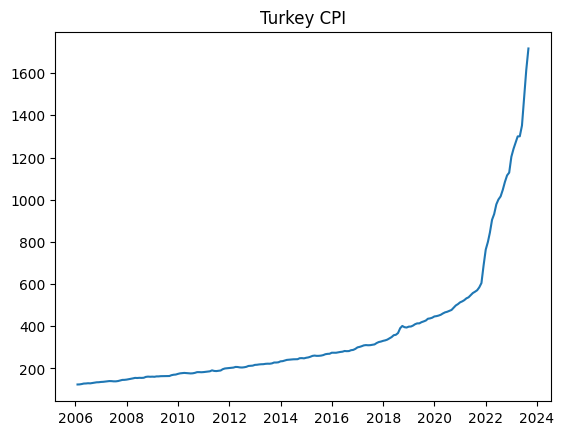

In [74]:
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')-pd.offsets.MonthBegin(1)
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure()
plt.title("Turkey CPI")

plt.plot(df)
plt.show()


In [75]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-05-31,19.719514
2023-06-30,23.106042
2023-07-31,26.470338


In [76]:
dates= pd.date_range('2006-02-01','2023-10-01' , freq='1M')-pd.offsets.MonthBegin(1)

            
df6=df6.set_index(dates)


df6

,USD/TL
2006-02-01,1.326535
2006-03-01,1.335139
2006-04-01,1.337345
2006-05-01,1.420659
2006-06-01,1.600536
...,...
2023-05-01,19.719514
2023-06-01,23.106042
2023-07-01,26.470338
2023-08-01,26.999127


In [77]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
money

,Tarih,TP_PR_ARZ13
0,2006-2,2.423895e+08
1,2006-3,2.494857e+08
2,2006-4,2.521919e+08
3,2006-5,2.751947e+08
4,2006-6,2.791388e+08
...,...,...
207,2023-5,9.409317e+09
208,2023-6,1.083453e+10
209,2023-7,1.147848e+10
210,2023-8,1.202532e+10


In [78]:
#Cleaning the data

money_supply=pd.DataFrame(money)
money_supply.columns=["Tarih","Para Arzi"]
money_supply["Para Arzi"]=money_supply["Para Arzi"].astype(float)
money_supply


,Tarih,Para Arzi
0,2006-2,2.423895e+08
1,2006-3,2.494857e+08
2,2006-4,2.521919e+08
3,2006-5,2.751947e+08
4,2006-6,2.791388e+08
...,...,...
207,2023-5,9.409317e+09
208,2023-6,1.083453e+10
209,2023-7,1.147848e+10
210,2023-8,1.202532e+10


In [79]:
money_supply=money_supply.set_index(dates)
money_supply["Para Arzi"]=money_supply["Para Arzi"]/1e+08
money_supply
dfn=pd.DataFrame(money_supply)
del dfn["Tarih"]
dfn


,Para Arzi
2006-02-01,2.423895
2006-03-01,2.494857
2006-04-01,2.521919
2006-05-01,2.751947
2006-06-01,2.791388
...,...
2023-05-01,94.093167
2023-06-01,108.345324
2023-07-01,114.784753
2023-08-01,120.253199


In [80]:
brent=evds.get_data(["TP.BRENTPETROL.EUBP"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
brent

,Tarih,TP_BRENTPETROL_EUBP
0,01-02-2006,65.64
1,02-02-2006,63.49
2,03-02-2006,62.54
3,06-02-2006,63.32
4,07-02-2006,61.64
...,...,...
4594,12-09-2023,93.58
4595,13-09-2023,93.04
4596,14-09-2023,95.20
4597,15-09-2023,95.55


In [81]:
brent['Tarih'] = pd.to_datetime(brent['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
brent.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
brent = brent.resample('M').mean()

# Sonucu görüntüle
brent

,TP_BRENTPETROL_EUBP
Tarih,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-05-31,75.466000
2023-06-30,74.839091
2023-07-31,80.108095


In [82]:

brent1=pd.DataFrame(brent)
brent1.columns=["Brent"]
brent1


,Brent
Tarih,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-05-31,75.466000
2023-06-30,74.839091
2023-07-31,80.108095


In [83]:
df14=pd.DataFrame()
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')-pd.offsets.MonthBegin(1)

df14["Brent"]=brent1["Brent"]
df14["TIME"]=dates
df14['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df14 = df14.set_index(['TIME'])
df14

C:\Users\Bora\AppData\Local\Temp\ipykernel_1620\3566834801.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)


,Brent
TIME,
2006-02-01,60.210000
2006-03-01,62.064783
2006-04-01,70.260000
2006-05-01,69.776957
2006-06-01,68.555909
...,...
2023-05-01,75.466000
2023-06-01,74.839091
2023-07-01,80.108095


In [84]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
207,2023-5,8.804344e+09
208,2023-6,9.564604e+09
209,2023-7,9.846895e+09
210,2023-8,9.923806e+09


In [85]:
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')-pd.offsets.MonthBegin(1)
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
207,2023-5,88.043441
208,2023-6,95.646045
209,2023-7,98.468952
210,2023-8,99.238055


In [86]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=dates
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3

C:\Users\Bora\AppData\Local\Temp\ipykernel_1620\2513009782.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)


,Kredi
TIME,
2006-02-01,1.381847
2006-03-01,1.481222
2006-04-01,1.527510
2006-05-01,1.664881
2006-06-01,1.740395
...,...
2023-05-01,88.043441
2023-06-01,95.646045
2023-07-01,98.468952


In [87]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.iloc[:59,1]=5
pfaiz.iloc[210,1]=25
pfaiz.iloc[211,1]=30
pfaiz


,Tarih,TP_APIFON4
0,2006-2,5.00
1,2006-3,5.00
2,2006-4,5.00
3,2006-5,5.00
4,2006-6,5.00
...,...,...
207,2023-5,9.09
208,2023-6,12.84
209,2023-7,17.50
210,2023-8,25.00


In [88]:
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')-pd.offsets.MonthBegin(1)
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

C:\Users\Bora\AppData\Local\Temp\ipykernel_1620\3293406371.py:6: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)


,Politika Faizi
TIME,
2006-02-01,5.00
2006-03-01,5.00
2006-04-01,5.00
2006-05-01,5.00
2006-06-01,5.00
...,...
2023-05-01,9.09
2023-06-01,12.84
2023-07-01,17.50


In [89]:
faiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
faiz=faiz.set_index(dates)
del faiz["Tarih"]
faiz.columns=["Faiz"]
faiz

,Faiz
2006-02-01,17.297500
2006-03-01,17.008000
2006-04-01,16.207500
2006-05-01,16.300000
2006-06-01,19.670000
...,...
2023-05-01,32.022500
2023-06-01,38.560000
2023-07-01,45.825000
2023-08-01,45.765000


In [90]:
X=pd.concat([df6["USD/TL"],df14.Brent,df3.Kredi,faiz],axis=1)



In [91]:
y=pd.DataFrame(df["CPI"])
y["CPI"]=y["CPI"].astype(float)
y


,CPI
2006-02-01,123.84
2006-03-01,124.18
2006-04-01,125.84
2006-05-01,128.20
2006-06-01,128.63
...,...
2023-05-01,1300.60
2023-06-01,1351.59
2023-07-01,1479.84
2023-08-01,1614.31


In [92]:
X["TÜFE"]=y["CPI"]
data=X
data

,USD/TL,Brent,Kredi,Faiz,TÜFE
2006-02-01,1.326535,60.210000,1.381847,17.297500,123.84
2006-03-01,1.335139,62.064783,1.481222,17.008000,124.18
2006-04-01,1.337345,70.260000,1.527510,16.207500,125.84
2006-05-01,1.420659,69.776957,1.664881,16.300000,128.20
2006-06-01,1.600536,68.555909,1.740395,19.670000,128.63
...,...,...,...,...,...
2023-05-01,19.719514,75.466000,88.043441,32.022500,1300.60
2023-06-01,23.106042,74.839091,95.646045,38.560000,1351.59
2023-07-01,26.470338,80.108095,98.468952,45.825000,1479.84
2023-08-01,26.999127,86.147727,99.238055,45.765000,1614.31


In [93]:
import pandas as pd
from sklearn.linear_model import LinearRegression



# Hareketli pencere boyutunu belirleyin
window_size = 12  # Örnek olarak 12 aylık bir pencere

# Hareketli pencere regresyonunu uygulama
results = []  # Tahmin sonuçlarını saklamak için bir liste

for i in range(len(data) - window_size + 1):
    window_data = data[i:i+window_size]  # Hareketli pencereyi seçin
    
    # Regresyon modelini oluşturun
    X = window_data[["USD/TL","Brent","Kredi","Faiz"]]  # Bağımsız değişkenler
    y = window_data['TÜFE']  # Hedef değişken
    
    model = LinearRegression()
    model.fit(X, y)  # Modeli eğitin
    
    # Tahmin yapın
    last_observation = data.iloc[i + window_size - 1][["USD/TL","Brent","Kredi","Faiz"]].values.reshape(1, -1)
    prediction = model.predict(last_observation)
    
    results.append(prediction[0])  # Tahmin sonucunu listeye ekleyin

# Tahmin sonuçlarını bir veri çerçevesine ekleyin
results_df = pd.DataFrame({'Tahmin': results})

# Orijinal veri ile tahminleri birleştirin
final_df = pd.concat([data, results_df], axis=1)

# Sonucu görüntüleme
print(final_df)


c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegressi

                       USD/TL      Brent     Kredi     Faiz    TÜFE  \
2006-02-01 00:00:00  1.326535  60.210000  1.381847  17.2975  123.84   
2006-03-01 00:00:00  1.335139  62.064783  1.481222  17.0080  124.18   
2006-04-01 00:00:00  1.337345  70.260000  1.527510  16.2075  125.84   
2006-05-01 00:00:00  1.420659  69.776957  1.664881  16.3000  128.20   
2006-06-01 00:00:00  1.600536  68.555909  1.740395  19.6700  128.63   
...                       ...        ...       ...      ...     ...   
196                       NaN        NaN       NaN      NaN     NaN   
197                       NaN        NaN       NaN      NaN     NaN   
198                       NaN        NaN       NaN      NaN     NaN   
199                       NaN        NaN       NaN      NaN     NaN   
200                       NaN        NaN       NaN      NaN     NaN   

                          Tahmin  
2006-02-01 00:00:00          NaN  
2006-03-01 00:00:00          NaN  
2006-04-01 00:00:00          NaN  
2006-05

c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegressi

In [94]:
data=data.iloc[11:]
data

,USD/TL,Brent,Kredi,Faiz,TÜFE
2007-01-01,1.426660,53.681429,1.934805,23.727500,135.84
2007-02-01,1.396940,57.555789,1.931193,23.032500,136.42
2007-03-01,1.409632,62.050455,1.998175,22.398000,137.67
2007-04-01,1.361815,67.485789,2.032833,21.660000,139.33
2007-05-01,1.338283,67.212273,2.058730,21.250000,140.03
...,...,...,...,...,...
2023-05-01,19.719514,75.466000,88.043441,32.022500,1300.60
2023-06-01,23.106042,74.839091,95.646045,38.560000,1351.59
2023-07-01,26.470338,80.108095,98.468952,45.825000,1479.84
2023-08-01,26.999127,86.147727,99.238055,45.765000,1614.31


In [95]:
results_df=results_df.set_index(data.index) 
results_df

,Tahmin
2007-01-01,135.629442
2007-02-01,135.877535
2007-03-01,137.363764
2007-04-01,139.030010
2007-05-01,139.910619
...,...
2023-05-01,1313.407615
2023-06-01,1353.334742
2023-07-01,1459.925302
2023-08-01,1573.489483


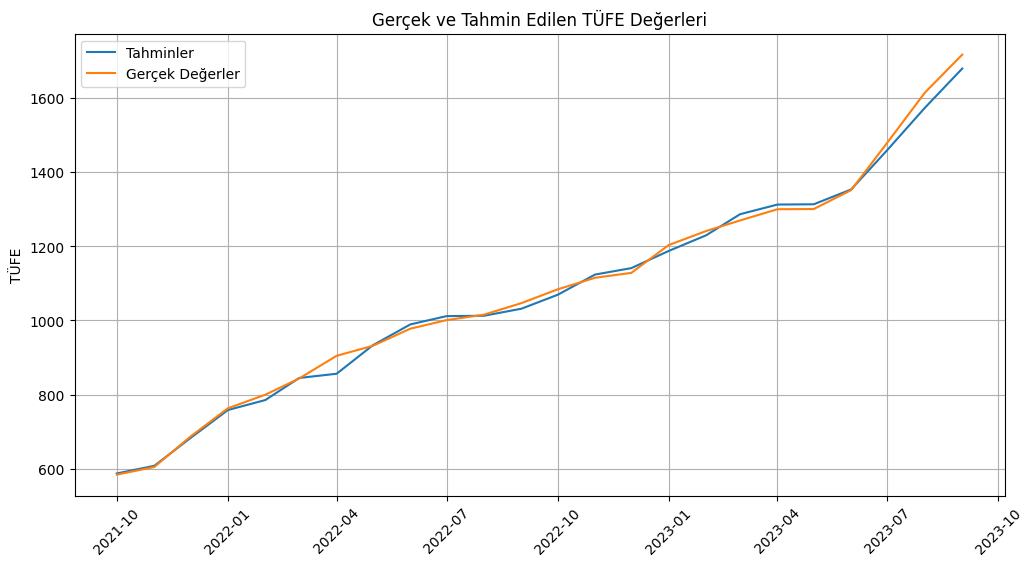

In [96]:
import matplotlib.pyplot as plt

# Orijinal veri ile tahminleri birleştirin (results_df ve data kullanıldı)
final_df = pd.concat([data, results_df], axis=1)

# Tahmin ve gerçek değerleri karşılaştırın
plt.figure(figsize=(12, 6))
plt.plot(results_df['Tahmin'].tail(24), label='Tahminler')
plt.plot(data['TÜFE'].tail(24), label='Gerçek Değerler')

plt.ylabel('TÜFE')
plt.title('Gerçek ve Tahmin Edilen TÜFE Değerleri')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [97]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df14.astype(float),
                                order=(0,1,0),
                                seasonal_order=(2, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [98]:
pred = results.get_prediction(start=pd.to_datetime('2016-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [99]:
pred_ci['Predicted'] = (pred_ci["lower Brent"] + pred_ci["upper Brent"])/2
pred_ci['Observed'] = df14["Brent"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Brent,upper Brent,Predicted,Observed,"Diff, %%"
2022-12-01,76.751519,106.893703,91.822611,80.996667,13.365913
2023-01-01,70.336234,100.478419,85.407327,82.515909,3.504073
2023-02-01,69.704250,99.846434,84.775342,82.585000,2.652227
2023-03-01,66.270878,96.413062,81.341970,78.434348,3.707077
2023-04-01,52.822248,82.964432,67.893340,84.739474,-19.879913
2023-05-01,78.134406,108.276590,93.205498,75.466000,23.506610
2023-06-01,69.538200,99.680384,84.609292,74.839091,13.054943
2023-07-01,57.187304,87.329488,72.258396,80.108095,-9.798884
2023-08-01,60.294501,90.436686,75.365593,86.147727,-12.515866
2023-09-01,66.085770,96.227955,81.156862,92.645000,-12.400170


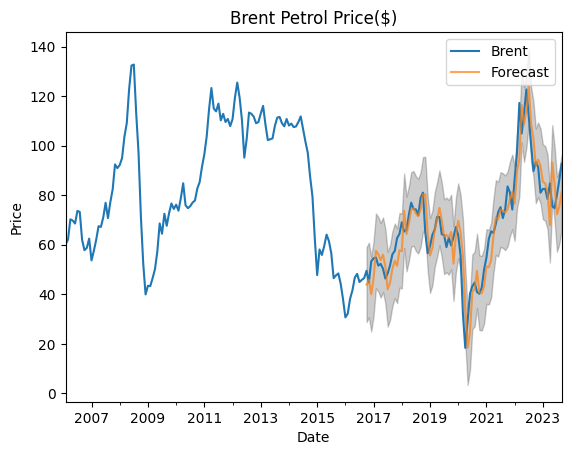

In [100]:
ax = df14['2003':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Brent Petrol Price($)")
plt.legend()
plt.show()

In [101]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

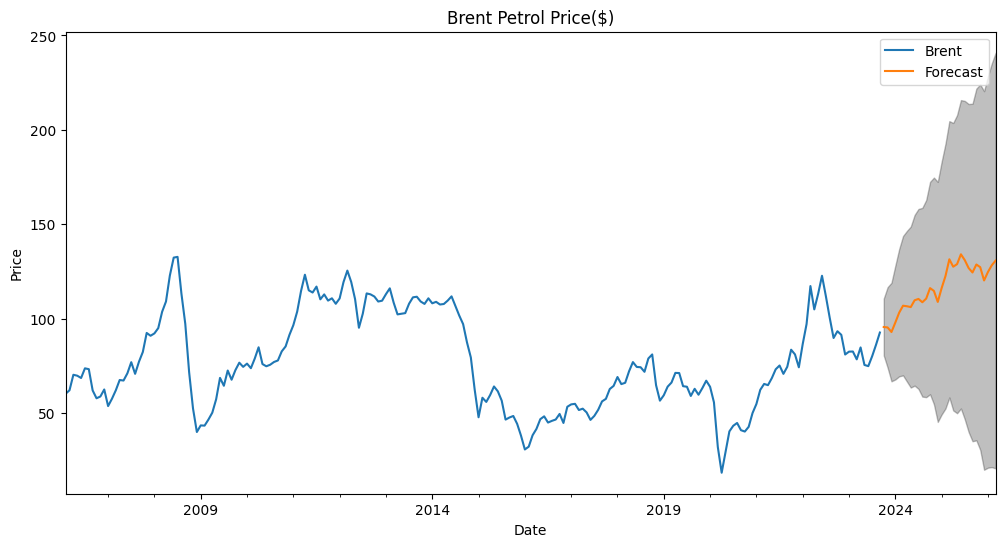

In [102]:
ax = df14.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Brent Petrol Price($)")

plt.legend()

plt.show()

In [103]:
brenttahmin=pd.DataFrame
pred_ci['Mean'] = (pred_ci["lower Brent"] + pred_ci["upper Brent"])/2
brenttahmin=pred_ci["Mean"]
brenttahmin=pd.DataFrame(brenttahmin)
brenttahmin.columns=["Brent"]
brenttahmin1=pd.DataFrame({"Brent":[95]})
brenttahmin1["Tarih"]="2023-09-01"
brenttahmin1=brenttahmin1.set_index("Tarih") 
brenttahmin=pd.concat([brenttahmin1,brenttahmin],axis=0)
brenttahmin



,Brent
2023-09-01,95.000000
2023-10-01 00:00:00,95.553750
2023-11-01 00:00:00,95.337272
2023-12-01 00:00:00,92.910005
2024-01-01 00:00:00,97.919790
2024-02-01 00:00:00,103.149827
2024-03-01 00:00:00,106.839247
2024-04-01 00:00:00,106.559836
2024-05-01 00:00:00,106.122597
2024-06-01 00:00:00,109.714004


In [104]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(dfn["Para Arzi"].astype(float),
                                order=(1,1,1),
                                seasonal_order=(0,1,1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [105]:
pred = results.get_prediction(start=pd.to_datetime('2016-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [106]:
pred_ci['Predicted'] = (pred_ci["lower Para Arzi"] + pred_ci["upper Para Arzi"])/2
pred_ci['Observed'] = dfn["Para Arzi"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Para Arzi,upper Para Arzi,Predicted,Observed,"Diff, %%"
2022-12-01,80.517736,84.761377,82.639557,82.127970,0.622914
2023-01-01,83.123145,87.366643,85.244894,84.330974,1.083730
2023-02-01,85.497501,89.740858,87.619179,86.852197,0.883090
2023-03-01,88.925309,93.168645,91.046977,90.592762,0.501382
2023-04-01,92.459712,96.702909,94.581311,95.059993,-0.503558
2023-05-01,97.391132,101.634193,99.512662,94.093167,5.759711
2023-06-01,96.131076,100.374003,98.252540,108.345324,-9.315385
2023-07-01,110.996305,115.239100,113.117703,114.784753,-1.452327
2023-08-01,117.711362,121.954027,119.832695,120.253199,-0.349683
2023-09-01,123.326308,127.568845,125.447577,121.751647,3.035630


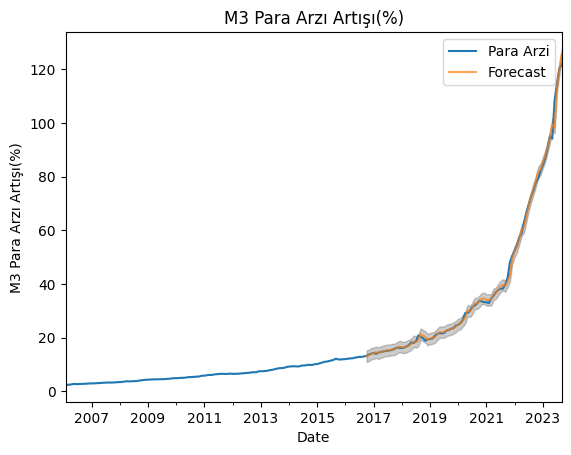

In [107]:
ax = dfn['2003':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.xlabel('Date')
plt.ylabel('M3 Para Arzı Artışı(%)')
plt.title("M3 Para Arzı Artışı(%)")
plt.legend()
plt.show()

In [108]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

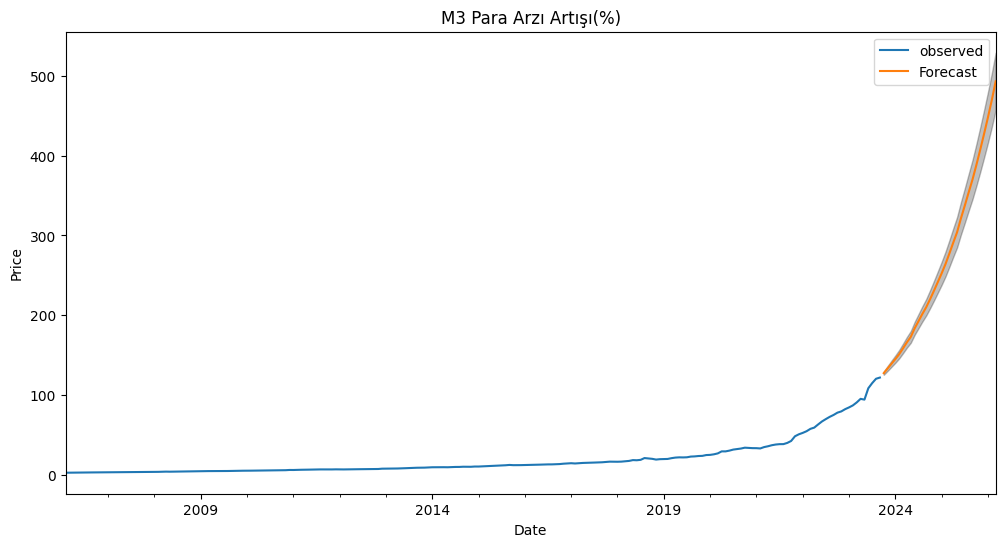

In [109]:
ax = dfn["Para Arzi"].plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("M3 Para Arzı Artışı(%)")

plt.legend()

plt.show()

In [110]:
import random
import numpy as np
pred_ci['Mean'] = (pred_ci["lower Para Arzi"] + pred_ci["upper Para Arzi"])/2
paraarzitahmin=pred_ci["Mean"]
paraarzitahmin=pd.DataFrame(paraarzitahmin)
paraarzitahmin.columns=["Para Arzi Tahmin"]
paraarzitahmin1=pd.DataFrame({"Para Arzi Tahmin":[120.8]})
paraarzitahmin1["Tarih"]="2023-09-01"
paraarzitahmin1=paraarzitahmin1.set_index("Tarih") 
paraarzitahmin1=pd.concat([paraarzitahmin1,paraarzitahmin],axis=0)
paraarzitahmin1







,Para Arzi Tahmin
2023-09-01,120.800000
2023-10-01 00:00:00,127.298537
2023-11-01 00:00:00,133.139900
2023-12-01 00:00:00,139.073482
2024-01-01 00:00:00,144.862416
2024-02-01 00:00:00,151.048329
2024-03-01 00:00:00,158.410196
2024-04-01 00:00:00,165.982334
2024-05-01 00:00:00,172.735593
2024-06-01 00:00:00,183.410890


In [111]:
y=float(input('Para Arzi Aylık En Fazla % Kaç Artacağını Girin: '))
def paraarziassumption(y):
   drop_percentage = random.uniform(1+(y/300), 1+(y/100))
   
   paraarzitahmin1["Para Arzi Assumption 2"]=paraarzitahmin1["Para Arzi Tahmin"]
   
   for i in range(0, len(paraarzitahmin)-1):
   
      paraarzitahmin1["Para Arzi Assumption 2"][i+1]=paraarzitahmin1["Para Arzi Assumption 2"][i]*drop_percentage
   return paraarzitahmin1
      
paraarziassumption(y)


,Para Arzi Tahmin,Para Arzi Assumption 2
2023-09-01,120.800000,120.800000
2023-10-01 00:00:00,127.298537,123.350312
2023-11-01 00:00:00,133.139900,125.954467
2023-12-01 00:00:00,139.073482,128.613600
2024-01-01 00:00:00,144.862416,131.328872
2024-02-01 00:00:00,151.048329,134.101468
2024-03-01 00:00:00,158.410196,136.932599
2024-04-01 00:00:00,165.982334,139.823501
2024-05-01 00:00:00,172.735593,142.775435
2024-06-01 00:00:00,183.410890,145.789689


In [112]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df6["USD/TL"].astype(float),
                                order=(0,1,1),
                                seasonal_order=(1,1,1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [113]:
pred = results.get_prediction(start=pd.to_datetime('2021-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [114]:
pred_ci['Predicted'] = (pred_ci["lower USD/TL"] + pred_ci["upper USD/TL"])/2
pred_ci['Observed'] = df6["USD/TL"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower USD/TL,upper USD/TL,Predicted,Observed,"Diff, %%"
2022-12-01,18.097145,19.609069,18.853107,18.670545,0.977804
2023-01-01,17.572854,19.084778,18.328816,18.791373,-2.461536
2023-02-01,18.160815,19.672739,18.916777,18.857210,0.315884
2023-03-01,18.676257,20.188181,19.432219,19.003478,2.256118
2023-04-01,18.389112,19.901036,19.145074,19.337032,-0.992695
2023-05-01,19.063686,20.575610,19.819648,19.719514,0.507788
2023-06-01,19.355110,20.867034,20.111072,23.106042,-12.961850
2023-07-01,24.483951,25.995875,25.239913,26.470338,-4.648317
2023-08-01,26.622929,28.134853,27.378891,26.999127,1.406577
2023-09-01,26.098026,27.609950,26.853988,26.915118,-0.227118


In [115]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

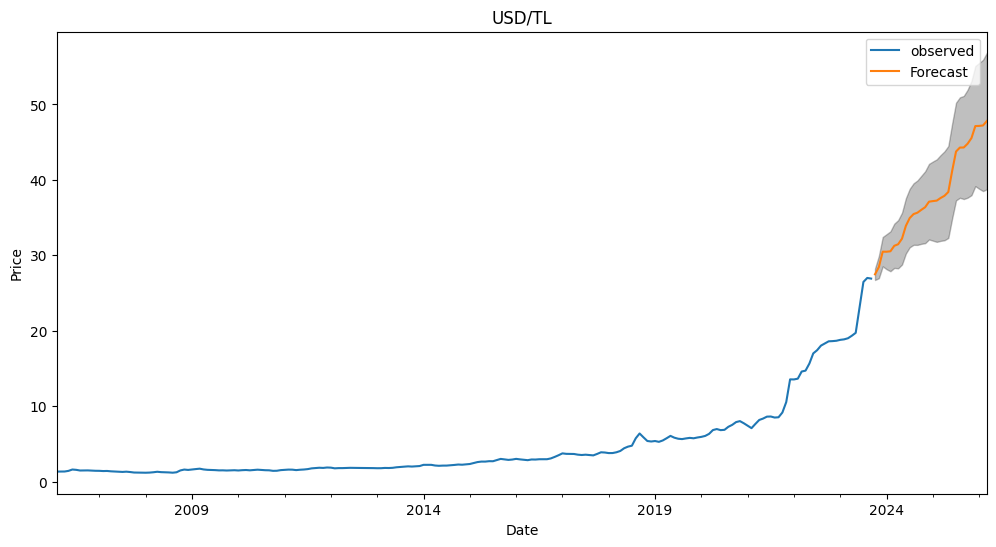

In [116]:
ax = df6["USD/TL"].plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("USD/TL")

plt.legend()

plt.show()

In [117]:
pred_ci['Mean'] = (pred_ci["lower USD/TL"] + pred_ci["upper USD/TL"])/2
usdtahmin=pred_ci["Mean"]
usdtahmin=pd.DataFrame(usdtahmin)
usdtahmin.columns=["USD Tahmin"]
usdtahmin1=pd.DataFrame({"USD Tahmin":[27.20]})
usdtahmin1["Tarih"]="2023-09-01"
usdtahmin1=usdtahmin1.set_index("Tarih") 
usdtahmin1=pd.concat([usdtahmin1,usdtahmin],axis=0)
usdtahmin1








,USD Tahmin
2023-09-01,27.200000
2023-10-01 00:00:00,27.479554
2023-11-01 00:00:00,28.440256
2023-12-01 00:00:00,30.481267
2024-01-01 00:00:00,30.475490
2024-02-01 00:00:00,30.534075
2024-03-01 00:00:00,31.261409
2024-04-01 00:00:00,31.465933
2024-05-01 00:00:00,32.211148
2024-06-01 00:00:00,33.902057


In [118]:
import random
x=float(input('Dolar/TL Aylık En Fazla % Kaç Artacağını Girin:   '))
def usdassumption(x):
    
  drop_percentage = random.uniform(1+(x/200), 1+(x/100))
  usdtahmin1["USD Tahmin Assumption 2"]=usdtahmin1["USD Tahmin"]
  for i in range(0, len(usdtahmin1)-3):
   
    usdtahmin1["USD Tahmin Assumption 2"][i+3]=usdtahmin1["USD Tahmin Assumption 2"][i+2]*drop_percentage

  return usdtahmin1

usdassumption(x)
  



,USD Tahmin,USD Tahmin Assumption 2
2023-09-01,27.200000,27.200000
2023-10-01 00:00:00,27.479554,27.479554
2023-11-01 00:00:00,28.440256,28.440256
2023-12-01 00:00:00,30.481267,29.476436
2024-01-01 00:00:00,30.475490,30.550369
2024-02-01 00:00:00,30.534075,31.663428
2024-03-01 00:00:00,31.261409,32.817040
2024-04-01 00:00:00,31.465933,34.012682
2024-05-01 00:00:00,32.211148,35.251886
2024-06-01 00:00:00,33.902057,36.536239


In [119]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df3.astype(float),
                                order=(3,1,0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [120]:
pred = results.get_prediction(start=pd.to_datetime('2021-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [121]:
pred_ci['Predicted'] = (pred_ci["lower Kredi"] + pred_ci["upper Kredi"])/2
pred_ci['Observed'] = df3["Kredi"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Kredi,upper Kredi,Predicted,Observed,"Diff, %%"
2022-12-01,69.507872,72.374568,70.941220,72.851339,-2.621941
2023-01-01,72.587786,75.454482,74.021134,75.079809,-1.410067
2023-02-01,75.583639,78.450334,77.016987,77.112692,-0.124111
2023-03-01,78.748175,81.614871,80.181523,82.109915,-2.348550
2023-04-01,83.767064,86.633759,85.200411,85.721139,-0.607466
2023-05-01,87.390660,90.257355,88.824007,88.043441,0.886570
2023-06-01,89.555914,92.422609,90.989261,95.646045,-4.868767
2023-07-01,97.449509,100.316205,98.882857,98.468952,0.420341
2023-08-01,98.874990,101.741686,100.308338,99.238055,1.078500
2023-09-01,101.501538,104.368233,102.934886,100.798086,2.119881


In [122]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

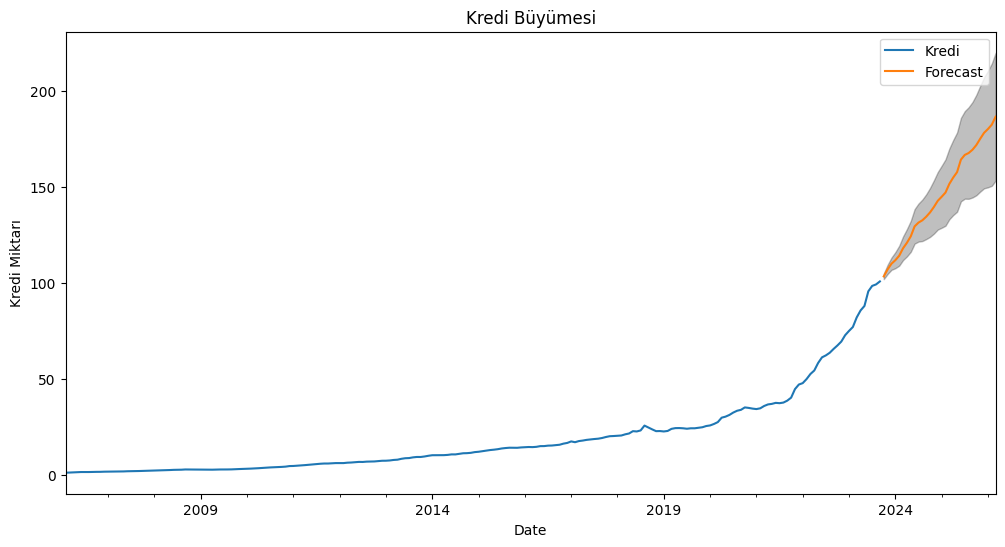

In [123]:
ax = df3.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Kredi Miktarı')
plt.title("Kredi Büyümesi")

plt.legend()

plt.show()

In [124]:
import random
pred_ci['Mean'] = (pred_ci["lower Kredi"] + pred_ci["upper Kredi"])/2
kreditahmin=pred_ci["Mean"]
kreditahmin=pd.DataFrame(kreditahmin)
kreditahmin.columns=["Kredi Tahmin"]
kreditahmin1=pd.DataFrame({"Kredi Tahmin":[100.32]})
kreditahmin1["Tarih"]="2023-09-01"
kreditahmin1=kreditahmin1.set_index("Tarih") 
kreditahmin1=pd.concat([kreditahmin1,kreditahmin],axis=0)
kreditahmin1




,Kredi Tahmin
2023-09-01,100.320000
2023-10-01 00:00:00,103.407075
2023-11-01 00:00:00,107.037196
2023-12-01 00:00:00,109.993523
2024-01-01 00:00:00,111.817846
2024-02-01 00:00:00,114.142137
2024-03-01 00:00:00,118.011931
2024-04-01 00:00:00,120.866035
2024-05-01 00:00:00,124.210401
2024-06-01 00:00:00,129.401273


In [125]:
z=float(input('Kredi Hacmi Aylık En Fazla % Kaç Artacağını Girin: '))
def krediassumption(z):

   drop_percentage = random.uniform(0.97, 1+(z/100))
   drop_percentage1=random.uniform(0.005, 0.01)
   kreditahmin1["Kredi Tahmin Assumption 2"]=kreditahmin1["Kredi Tahmin"]
   for i in range(0, len(kreditahmin)-1):
   
      kreditahmin1["Kredi Tahmin Assumption 2"][i+1]=kreditahmin1["Kredi Tahmin Assumption 2"][i]*drop_percentage
   return kreditahmin1
krediassumption(z)
   

,Kredi Tahmin,Kredi Tahmin Assumption 2
2023-09-01,100.320000,100.320000
2023-10-01 00:00:00,103.407075,97.623335
2023-11-01 00:00:00,107.037196,94.999158
2023-12-01 00:00:00,109.993523,92.445521
2024-01-01 00:00:00,111.817846,89.960527
2024-02-01 00:00:00,114.142137,87.542331
2024-03-01 00:00:00,118.011931,85.189138
2024-04-01 00:00:00,120.866035,82.899201
2024-05-01 00:00:00,124.210401,80.670818
2024-06-01 00:00:00,129.401273,78.502335


In [126]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(faiz.astype(float),
                                order=(1,1,0),
                                seasonal_order=(1, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [127]:
pred = results.get_prediction(start=pd.to_datetime('2021-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [128]:
pred_ci['Predicted'] = (pred_ci["lower Faiz"] + pred_ci["upper Faiz"])/2
pred_ci['Observed'] = faiz["Faiz"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Faiz,upper Faiz,Predicted,Observed,"Diff, %%"
2022-12-01,26.189544,32.150452,29.169998,28.718000,1.573918
2023-01-01,24.411273,30.372181,27.391727,28.680000,-4.491886
2023-02-01,25.140917,31.101825,28.121371,28.255000,-0.472939
2023-03-01,24.882264,30.843171,27.862717,26.508000,5.110598
2023-04-01,23.272015,29.232923,26.252469,29.227500,-10.178875
2023-05-01,27.886597,33.847505,30.867051,32.022500,-3.608242
2023-06-01,30.583944,36.544851,33.564398,38.560000,-12.955400
2023-07-01,38.486979,44.447886,41.467432,45.825000,-9.509149
2023-08-01,47.342419,53.303326,50.322872,45.765000,9.959297
2023-09-01,43.911804,49.872712,46.892258,55.576667,-15.625998


In [129]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

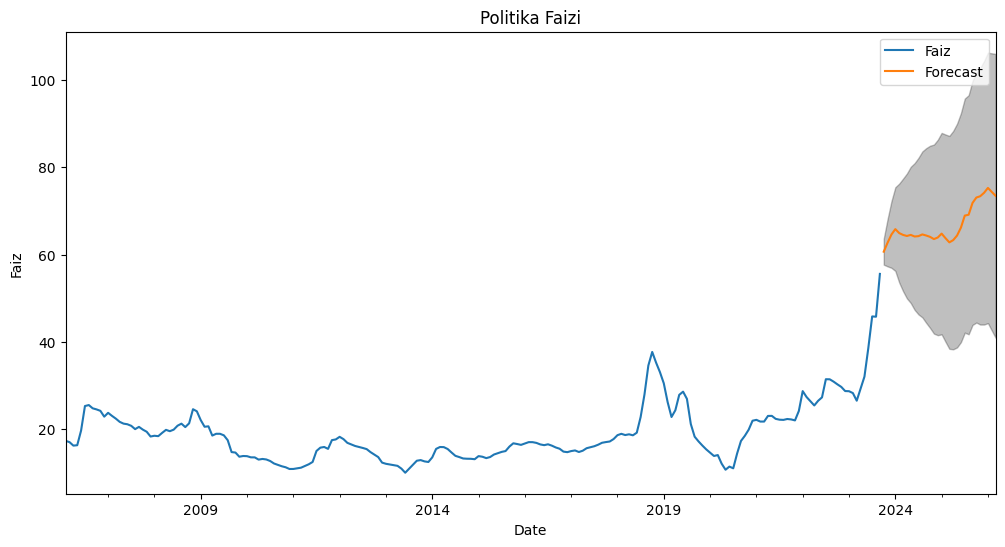

In [130]:
ax = faiz.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Faiz')
plt.title("Politika Faizi")

plt.legend()

plt.show()

In [131]:
pred_ci['Mean'] = (pred_ci["lower Faiz"] + pred_ci["upper Faiz"])/2
faiztahmin=pred_ci["Mean"]
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Faiz"]
faiztahmin["Faiz"]=faiztahmin["Faiz"].astype(int)
faiztahmin1=pd.DataFrame({"Faiz":[55.57]})
faiztahmin1["Tarih"]="2023-09-01"
faiztahmin1=faiztahmin1.set_index("Tarih") 
faiztahmin1=pd.concat([faiztahmin1,faiztahmin],axis=0)
faiztahmin1

,Faiz
2023-09-01,55.57
2023-10-01 00:00:00,60.00
2023-11-01 00:00:00,62.00
2023-12-01 00:00:00,64.00
2024-01-01 00:00:00,65.00
2024-02-01 00:00:00,64.00
2024-03-01 00:00:00,64.00
2024-04-01 00:00:00,64.00
2024-05-01 00:00:00,64.00
2024-06-01 00:00:00,64.00


In [132]:
forecast=pd.DataFrame()
forecast["USD/TL Tahmin"]=usdtahmin1["USD Tahmin"]
forecast["Brent Tahmin"]=brenttahmin
forecast["Kredi Tahmin"]=kreditahmin1["Kredi Tahmin"]   
forecast["Faiz Tahmin"]=faiztahmin1["Faiz"]

forecast.columns=["USD/TL","Brent","Kredi","Faiz"]
forecast

,USD/TL,Brent,Kredi,Faiz
2023-09-01,27.200000,95.000000,100.320000,55.57
2023-10-01 00:00:00,27.479554,95.553750,103.407075,60.00
2023-11-01 00:00:00,28.440256,95.337272,107.037196,62.00
2023-12-01 00:00:00,30.481267,92.910005,109.993523,64.00
2024-01-01 00:00:00,30.475490,97.919790,111.817846,65.00
2024-02-01 00:00:00,30.534075,103.149827,114.142137,64.00
2024-03-01 00:00:00,31.261409,106.839247,118.011931,64.00
2024-04-01 00:00:00,31.465933,106.559836,120.866035,64.00
2024-05-01 00:00:00,32.211148,106.122597,124.210401,64.00
2024-06-01 00:00:00,33.902057,109.714004,129.401273,64.00


In [133]:


# Gelecek 12 ay için tahminler yapın
future_predictions = model.predict(forecast.head(16))

# Tahmin sonuçlarını görüntüleme
print("Gelecek 12 Ay için TÜFE Tahminleri:")
print(future_predictions)


Gelecek 12 Ay için TÜFE Tahminleri:
[1691.19968832 1752.44236144 1808.76730011 1834.19178701 1906.1522083
 1982.98814673 2071.53906003 2112.48139191 2158.53504724 2264.57014744
 2298.57755206 2301.05601399 2345.34442697 2425.43672882 2453.30996432
 2452.14838328]


In [134]:
future_predictions=pd.DataFrame(future_predictions)
future_predictions=future_predictions.set_index(pd.date_range(start='2023-09-01', periods=16, freq='M'))
future_predictions.columns=["TÜFE"]
future_predictions

,TÜFE
2023-09-30,1691.199688
2023-10-31,1752.442361
2023-11-30,1808.767300
2023-12-31,1834.191787
2024-01-31,1906.152208
2024-02-29,1982.988147
2024-03-31,2071.539060
2024-04-30,2112.481392
2024-05-31,2158.535047
2024-06-30,2264.570147


In [135]:
tüfe=pd.concat([data,future_predictions])
tüfe=tüfe.drop("2023-09-01 00:00:00")
tüfe


,USD/TL,Brent,Kredi,Faiz,TÜFE
2007-01-01,1.426660,53.681429,1.934805,23.7275,135.840000
2007-02-01,1.396940,57.555789,1.931193,23.0325,136.420000
2007-03-01,1.409632,62.050455,1.998175,22.3980,137.670000
2007-04-01,1.361815,67.485789,2.032833,21.6600,139.330000
2007-05-01,1.338283,67.212273,2.058730,21.2500,140.030000
...,...,...,...,...,...
2024-08-31,NaN,NaN,NaN,NaN,2301.056014
2024-09-30,NaN,NaN,NaN,NaN,2345.344427
2024-10-31,NaN,NaN,NaN,NaN,2425.436729
2024-11-30,NaN,NaN,NaN,NaN,2453.309964


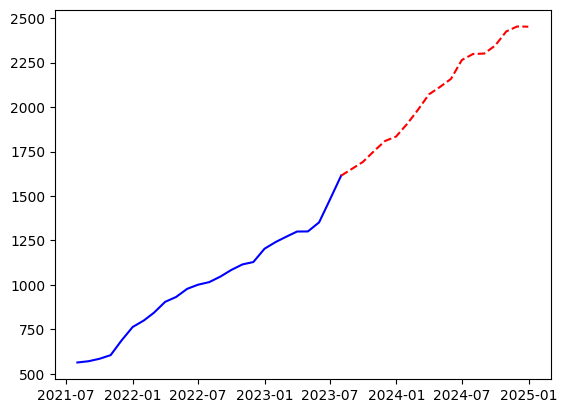

In [136]:
plt.plot(tüfe["TÜFE"].iloc[175:200], label="Gerçek Değerler", color="blue")
plt.plot(tüfe["TÜFE"].iloc[199:], label="Tahminler", color="red", linestyle="--")

In [137]:
tüfe=pd.DataFrame(tüfe["TÜFE"])
tüfe=tüfe.set_index(pd.date_range('2007-01-01','2025-01-01' , freq='1M')-pd.offsets.MonthBegin(1))
tüfe["12 Ay Önceki TÜFE"]=tüfe["TÜFE"].shift(12)
tüfe["Enflasyon"]=((tüfe["TÜFE"]/tüfe["12 Ay Önceki TÜFE"])-1)*100
tüfe=tüfe.dropna()
tüfe

,TÜFE,12 Ay Önceki TÜFE,Enflasyon
2008-01-01,146.940000,135.840000,8.171378
2008-02-01,148.840000,136.420000,9.104237
2008-03-01,150.270000,137.670000,9.152321
2008-04-01,152.790000,139.330000,9.660518
2008-05-01,155.070000,140.030000,10.740556
...,...,...,...
2024-08-01,2301.056014,1614.310000,42.541148
2024-09-01,2345.344427,1691.199688,38.679332
2024-10-01,2425.436729,1752.442361,38.403224
2024-11-01,2453.309964,1808.767300,35.634361


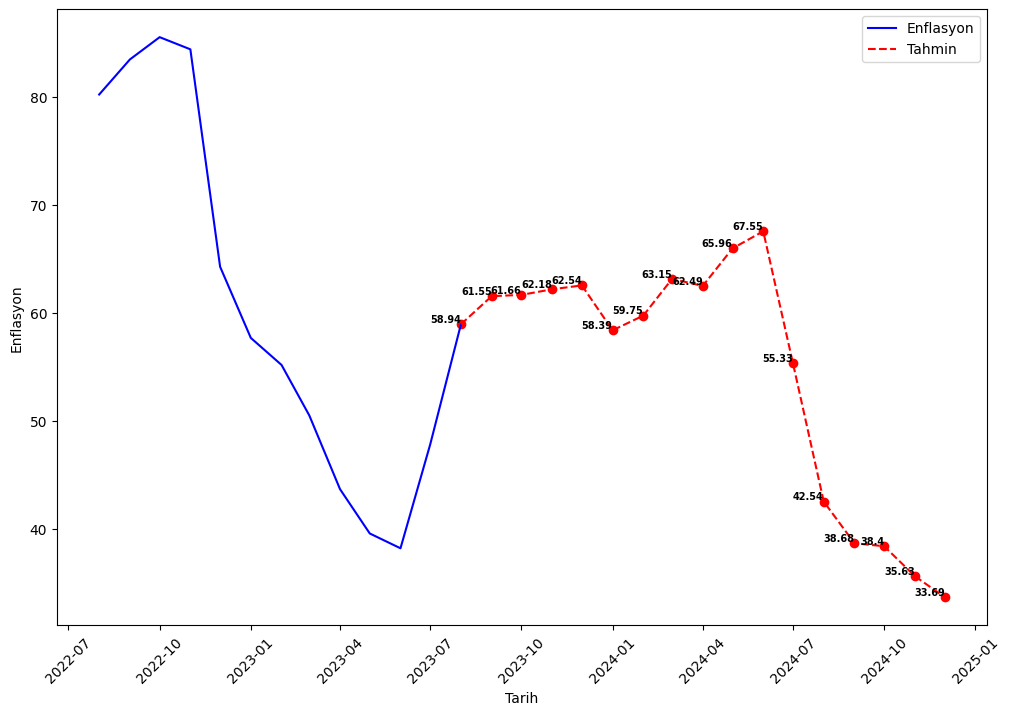

In [138]:
plt.figure(figsize=(12,8))
plt.plot(tüfe["Enflasyon"].iloc[175:188], label="Enflasyon", color="blue")
plt.plot(tüfe["Enflasyon"].iloc[187:], label="Tahmin", color="red", linestyle="--")
plt.legend()
plt.xticks(rotation=45)
for i in range(17):
    plt.scatter(tüfe.index[187+i], tüfe["Enflasyon"].iloc[187+i], color="red")
    plt.annotate(round(tüfe["Enflasyon"].iloc[187+i],2),(tüfe.index[187+i], tüfe["Enflasyon"].iloc[187+i]),fontsize=7,color="black",weight="bold",horizontalalignment='right',verticalalignment='bottom')

plt.xlabel("Tarih")
plt.ylabel("Enflasyon")
plt.show()


In [139]:
forecast

,USD/TL,Brent,Kredi,Faiz
2023-09-01,27.200000,95.000000,100.320000,55.57
2023-10-01 00:00:00,27.479554,95.553750,103.407075,60.00
2023-11-01 00:00:00,28.440256,95.337272,107.037196,62.00
2023-12-01 00:00:00,30.481267,92.910005,109.993523,64.00
2024-01-01 00:00:00,30.475490,97.919790,111.817846,65.00
2024-02-01 00:00:00,30.534075,103.149827,114.142137,64.00
2024-03-01 00:00:00,31.261409,106.839247,118.011931,64.00
2024-04-01 00:00:00,31.465933,106.559836,120.866035,64.00
2024-05-01 00:00:00,32.211148,106.122597,124.210401,64.00
2024-06-01 00:00:00,33.902057,109.714004,129.401273,64.00
